This fine contains the following script to analyse the backbone structures
- pLDDT / sequence
- RMSD / motif RMSD / TM-score
- RMSF
- SASA

Written by: Bo Zhang <zhangbo777@sjtu.edu.cn>

In [1]:
# import biotite and other tools
import biotite
import biotite.structure.io as strucio
import biotite.structure as struc
from biotite.structure.residues import get_residues
from biotite.structure import get_chains
from biotite.sequence import ProteinSequence
import numpy as np
import subprocess

### Part0 : extract backbone coordinates from biotite

Note the basic python object is atom rather than residue or chain!

In [9]:
# Biotite module forthe pdb/cif structures
def load_structure(fpath,chain=None):
    """
    loading atom from the fpath, from the given chain
    """
    structure = strucio.load_structure(fpath,model=1)
    aa_mask = struc.filter_amino_acids(structure)
    structure = structure[aa_mask]
    all_chains = get_chains(structure)
    if len(all_chains) == 0:
        raise ValueError('No chains found in the input file.')
    if chain is None:
        chain_ids = all_chains
    elif isinstance(chain, list):
        chain_ids = chain
    else:
        chain_ids = [chain] 
    for chain in chain_ids:
        if chain not in all_chains:
            raise ValueError(f'Chain {chain} not found in input file')
    chain_filter = [a.chain_id in chain_ids for a in structure]
    structure = structure[chain_filter]
    # filter the canonical amino acid
    aa_mask = struc.filter_amino_acids(structure)
    structure = structure[aa_mask]
    return structure

In [12]:
backbone = load_structure('./gpdl_inpainting/benchmark_set/2KL8.pdb')
print(f"type of backbone is {type(backbone)} , shape is {backbone.shape}")
print(f"type of backbone is {type(backbone.coord)} , shape is {backbone.coord.shape}")

type of backbone is <class 'biotite.structure.AtomArray'> , shape is (1416,)
type of backbone is <class 'numpy.ndarray'> , shape is (1416, 3)


### Part1 : extract pLDDT and sequence from the predicted structure

In [2]:
def extract_plddt(protein,chain_id=None):
    if isinstance(protein,str):
        # model = 1 to load a AtomArray object
        # extra_fields to load the b_factor column
        atom_array = strucio.load_structure(protein,model=1,extra_fields=["b_factor"])
    elif isinstance(protein, struc.AtomArrayStack):
        atom_array = protein[0]
    elif isinstance(protein, struc.AtomArray):
        atom_array = protein

    # add multiple chain sequence subtract function
    all_chains = get_chains(atom_array)
    if len(all_chains) == 0:
        raise ValueError('No chains found in the input file.')
    if chain_id is None:
        chain_ids = all_chains
    elif isinstance(chain_id, list):
        chain_ids = chain_id
    else:
        chain_ids = [chain_id] 
    for chain in chain_ids:
        if chain not in all_chains:
            raise ValueError(f'Chain {chain} not found in input file')
    chain_filter = [a.chain_id in chain_ids for a in atom_array]
    atom_array = atom_array[chain_filter]

    # mask canonical aa 
    aa_mask = struc.filter_canonical_amino_acids(atom_array)
    atom_array = atom_array[aa_mask]

    # ca atom only
    atom_array = atom_array[atom_array.atom_name == "CA"]

    plddt = np.array([i.b_factor for i in atom_array])

    return plddt, np.mean(plddt)

In [5]:
def extract_seq(protein, chain_id=None):
    if isinstance(protein, str):
        atom_array = strucio.load_structure(protein, model=1)
    elif isinstance(protein, struc.AtomArrayStack):
        atom_array = protein[0]
    elif isinstance(protein, struc.AtomArray):
        atom_array = protein
    aa_mask = struc.filter_canonical_amino_acids(atom_array)
    atom_array = atom_array[aa_mask]
    all_chains = get_chains(atom_array)
    if len(all_chains) == 0:
        raise ValueError('No chains found in the input file.')
    if chain_id is None:
        chain_ids = all_chains
    elif isinstance(chain, list):
        chain_ids = chain
    else:
        chain_ids = [chain]
    for chain in chain_ids:
        if chain not in all_chains:
            raise ValueError(f'Chain {chain} not found in input file')
    chain_filter = [a.chain_id in chain_ids for a in atom_array]
    atom_array = atom_array[chain_filter]
    # mask canonical aa
    aa_mask = struc.filter_amino_acids(atom_array)
    atom_array = atom_array[aa_mask]
    residue_identities = get_residues(atom_array)[1]
    seq = ''.join([ProteinSequence.convert_letter_3to1(r)
                  for r in residue_identities])
    return seq


In [8]:
seq = extract_seq("./gpdl_inpainting/benchmark_set/1BCF.pdb")
print(f"Length of 1BCF sequence is {len(seq)}")

Length of 1BCF sequence is 1896


### Part2 : RMSD/motif RMSD/TM-score

In the following command we provide two methods for RMSD, the first is to use Kabsch algorithm in biotite and the other is to use the third paryty software `TMalign`.

One can compute the motif RMSD by extract the motif positions

In [13]:
def rmsd(reference:str or struc.AtomArray,target: str or struc.AtomArray):
    """
    Input : 
    - reference : path of the reference protein structure file or the reference AtomArray
    - target : path of the target file or the target AtomArray
    This function calculate the backbone RMSD for two pdbs
    """
    if isinstance(reference,str):
        reference = strucio.load_structure(reference,model=1)
    if isinstance(target,str):
        target = strucio.load_structure(target,model=1)
    mask_reference = (((reference.atom_name == "N") | (reference.atom_name == "CA") | (reference.atom_name == "C") | (reference.atom_name == "O")) & (biotite.structure.filter_amino_acids(reference)))
    reference = reference[mask_reference]
    mask_target = (((target.atom_name == "N") | (target.atom_name == "CA") | (target.atom_name == "C") | (target.atom_name == "O")) & (biotite.structure.filter_amino_acids(target)) )
    target = target[mask_target]
    superimposed, _ = struc.superimpose(reference, target)
    rms = struc.rmsd(reference, superimposed)
    return rms

In [14]:
def motif_extract(position,structure_path,atom_part="all"):
    """
    subtract chain_id,res_id & atom option
    ignore the hetero elements

    DEMO:
    position = "A119-140,A63-82"
    motif_AtomArray = motif_extract(position,structure_path="./2kl8.pdb",atom_part="backbone")
    """
    position = position.split(",")
    if isinstance(structure_path,str):
        array = strucio.load_structure(structure_path,model=1)
    else:
        array = structure_path
    motif_array = []
    for i in position:
        chain_id = i[0]
        i = i.replace(chain_id,"")
        if "-" not in i: # single motif positions
            start = end = int(i)
        else:
            start,end = i.split("-")
            start,end = int(start),int(end)
        if atom_part == "all":
            motif_array.append(array[(array.chain_id==chain_id) & (array.res_id <= end) & (array.res_id >= start) & (array.hetero==False)])
        elif atom_part == "ca":
            motif_array.append(array[(array.chain_id==chain_id) & (array.res_id <= end) & (array.res_id >= start) & (array.hetero==False) & (array.atom_name=="CA")])
        elif atom_part == "backbone":
            motif_array.append(array[(array.chain_id==chain_id) & (array.res_id <= end) & (array.res_id >= start) & (array.hetero==False) & ((array.atom_name=="N") | (array.atom_name=="CA")| (array.atom_name=="C") | (array.atom_name=="O"))])
    motif_AtomArray = motif_array[0]
    for i in range(len(motif_array)-1):
        motif_AtomArray += motif_array[i+1]
    return motif_AtomArray

In [15]:
def tmalign_wrapper(template, temp_pdbfile, TM_binary_path,force_alignment=None):
    if force_alignment == None:
        p = subprocess.Popen(f'{TM_binary_path} {template} {temp_pdbfile} | grep -E "RMSD|TM-score=" ', stdout=subprocess.PIPE, shell=True)
    else:
        p = subprocess.Popen(f'{TM_binary_path} {template} {temp_pdbfile} -I {force_alignment} | grep -E "RMSD|TM-score=" ', stdout=subprocess.PIPE, shell=True)
    output, __ = p.communicate()
    tm_rmsd  = float(str(output)[:-3].split("RMSD=")[-1].split(",")[0] )
    tm_score = float(str(output)[:-3].split("TM-score=")[-1].split("(if")[0] )
    return tm_rmsd, tm_score

def mmalign_wrapper(template, temp_pdbfile, MM_binary_path, force_alignment=None):
    if force_alignment == None:
        p = subprocess.Popen(f'{MM_binary_path} {template} {temp_pdbfile} | grep -E "RMSD|TM-score=" ', stdout=subprocess.PIPE, shell=True)
    else:
        p = subprocess.Popen(f'{MM_binary_path} {template} {temp_pdbfile} -I {force_alignment} | grep -E "RMSD|TM-score=" ', stdout=subprocess.PIPE, shell=True)
    output, __ = p.communicate()
    tm_rmsd  = float(str(output)[:-3].split("RMSD=")[-1].split(",")[0] )
    tm_score = float(str(output)[:-3].split("TM-score=")[-1].split("(normalized")[0] )
    return tm_rmsd, tm_score

### Part3 : RMSF
It represents the root mean square fluctuation for each atom in $T$ frames. This is useful when I have multiple conforamtions to see the flexibility of each atom such as NMR structure or molecular dynamics simmulation.

For the $i$ atom (CA atom), we can compute the average position and the flucutation 

$\bar{x}_i=\frac{1}{T}\sum\limits_{t=1}^T x_i$

$RMSF_{i}=\frac{1}{T}\sum\limits_{t=1}^T||x_{i,t} - \bar{x}_i||_2$ 



In [1]:
def RMSF(file_path):
    """
    Calculate the RMSF of a protein structure, useful for MD simulations and NMR structures
    """
    stack = strucio.load_structure(file_path)
    # We consider only CA atoms
    stack = stack[:, stack.atom_name == "CA"]
    # Superimposing all models of the structure onto the first model
    stack, transformation_tuple = struc.superimpose(stack[0], stack)
    print("RMSD for each model to first model:")
    print(struc.rmsd(stack[0], stack))
    # Calculate the RMSF relative to the average of all models
    average_structure = struc.average(stack)
    rmsf = struc.rmsf(average_structure, stack)
    return rmsf

RMSD for each model to first model:
[0.         0.7842643  1.0075767  0.5518028  0.8066345  1.0606678
 0.8738371  0.6260641  1.0057656  0.81440794 0.876283   1.353859
 0.93277985 0.8760094  0.99357325 0.40626574 0.31801927 1.1838906
 1.2347708  0.89114463 0.5553653  0.73639375 0.7856738  1.1019256
 0.67228884 1.1605636  0.98213965 1.2280884  0.79269636 0.8685473
 0.9386668  0.8356571  0.61650354 0.97335416 1.0322398  0.5555665
 1.1517522  0.8558534 ]


Text(0, 0.5, 'RMSF')

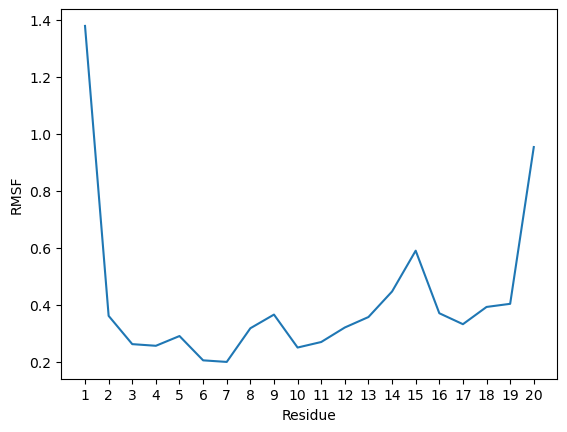

In [7]:
import biotite.database.rcsb as rcsb
import matplotlib.pyplot as plt

file_path = rcsb.fetch("1l2y", "pdb", "./")
rmsf = RMSF(file_path)
plt.plot(np.arange(1,len(rmsf)+1),rmsf)
plt.xlim(0,21)
plt.xticks(np.arange(1,21))
plt.xlabel("Residue")
plt.ylabel("RMSF")

### Part4 : SASA
Calculate the Solvent Accessible Surface Area (SASA) of a protein.This function uses the Shrake-Rupley (“rolling probe”) algorithm: Every atom is occupied by a evenly distributed point mesh. The points that can be reached by the “rolling probe”, are surface accessible.

https://www.biotite-python.org/apidoc/biotite.structure.sasa.html